In [18]:
import pandas as pd


data = pd.read_csv('gld_price_data.csv',parse_dates=['Date'])

#gold and silver prices are USD per ounce

# Sort by date just to be safe
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2290 non-null   datetime64[ns]
 1   SPX      2290 non-null   float64       
 2   GLD      2290 non-null   float64       
 3   USO      2290 non-null   float64       
 4   SLV      2290 non-null   float64       
 5   EUR/USD  2290 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 107.5 KB


,Date,SPX,GLD,USO,SLV,EUR/USD
0,2008-01-02,1447.160034,84.860001,78.470001,15.180,1.471692
1,2008-01-03,1447.160034,85.570000,78.370003,15.285,1.474491
2,2008-01-04,1411.630005,85.129997,77.309998,15.167,1.475492
3,2008-01-07,1416.180054,84.769997,75.500000,15.053,1.468299
4,2008-01-08,1390.189941,86.779999,76.059998,15.590,1.557099


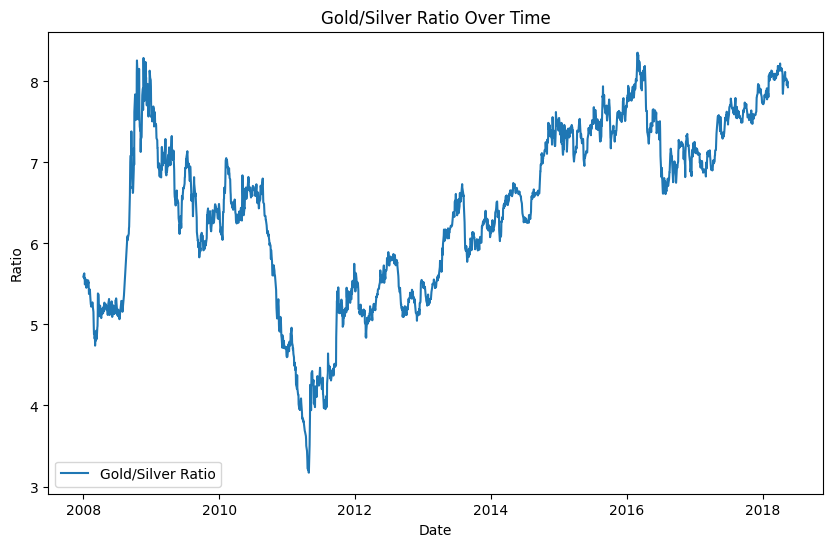

In [19]:
# Sort by date and reset index
data = data.sort_values('Date').reset_index(drop=True)

# Create Gold/Silver Ratio
data['Gold_Silver_Ratio'] = data['GLD'] / data['SLV']

# Define Trade Signal: 1 = buy silver, 0 = buy gold (using a simple rolling mean)
data['Trade_Signal'] = (data['Gold_Silver_Ratio'] > data['Gold_Silver_Ratio'].rolling(window=30).mean()).astype(int)

# Visualize the Gold/Silver Ratio and Trade Signal
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Gold_Silver_Ratio'], label='Gold/Silver Ratio')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Gold/Silver Ratio Over Time')
plt.legend()
plt.show()



In [20]:
# Split the dataset by date
train_data = data[data['Date'] < '2018-01-01']
test_data = data[data['Date'] >= '2018-01-01']

# Define features (X) and target (y) for both train and test sets
X_train = train_data[['GLD', 'SLV', 'Gold_Silver_Ratio']]
y_train = train_data['Trade_Signal']
X_test = test_data[['GLD', 'SLV', 'Gold_Silver_Ratio']]
y_test = test_data['Trade_Signal']



In [21]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



Model Accuracy: 0.632183908045977
Confusion Matrix:
 [[ 5 26]
 [ 6 50]]
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.16      0.24        31
           1       0.66      0.89      0.76        56

    accuracy                           0.63        87
   macro avg       0.56      0.53      0.50        87
weighted avg       0.59      0.63      0.57        87



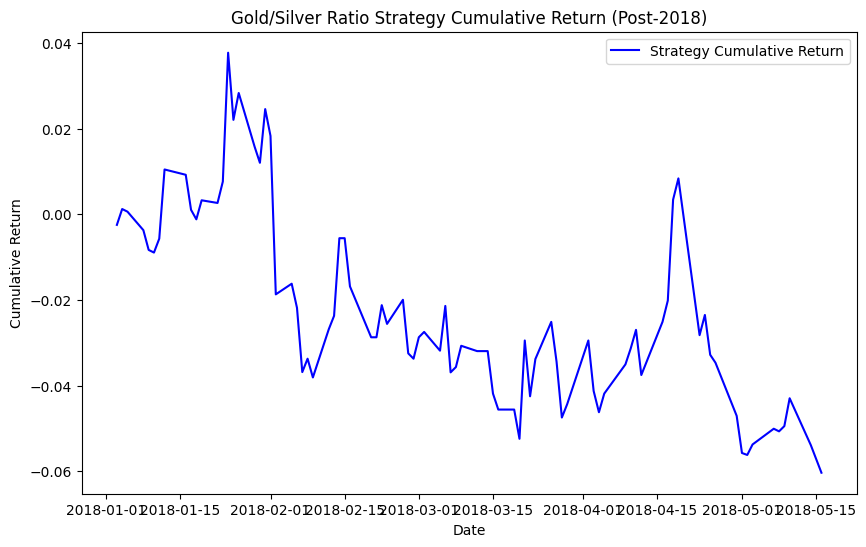

In [25]:
# Add predicted trade signal to test data using .loc to avoid SettingWithCopyWarning
test_data.loc[:, 'Predicted_Trade_Signal'] = y_pred

# Calculate daily returns for GLD and SLV
test_data.loc[:, 'Gold_Return'] = test_data['GLD'].pct_change()
test_data.loc[:, 'Silver_Return'] = test_data['SLV'].pct_change()

# Apply strategy: switch to silver returns when signal == 1, else gold returns
test_data.loc[:, 'Strategy_Return'] = test_data.apply(
    lambda row: row['Silver_Return'] if row['Predicted_Trade_Signal'] == 1 else row['Gold_Return'], axis=1
)

# Calculate cumulative returns of the strategy
test_data.loc[:, 'Cumulative_Strategy_Return'] = (1 + test_data['Strategy_Return']).cumprod() - 1

# Plot cumulative returns of the strategy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_data['Date'], test_data['Cumulative_Strategy_Return'], label='Strategy Cumulative Return', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Gold/Silver Ratio Strategy Cumulative Return (Post-2018)')
plt.legend()
plt.show()




In [24]:
# Conclusions

# The cumulative return plot for the strategy shows that:
# - If the strategy return is positive, the model was successful in predicting profitable trades.
# - If the return fluctuates significantly or trends downward, the model may require optimization, such as adjusting the `Trade_Signal` thresholds or model parameters.
  
# Next Steps:
# 1. Experiment with different rolling windows for the `Trade_Signal` calculation.
# 2. Explore additional features like gold and silver volatility or other macroeconomic indicators.
